In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
from scipy.stats import ttest_ind
from scipy.interpolate import make_interp_spline

traditional_csvFile = "csv/compressed_traditional_CSV.csv"
vpTree_csvFile = "csv/compressed_VPtree_CSV.csv"
kdTree_csvFile = "csv/compressed_kd_only_CSV.csv"
enhanced_csvFile = "csv/compressed_enhanced_CSV.csv"
multiTest_csvFile = "csv/multiTest_CSV.csv"
cnnModel_csvFile = "csv/trained_cnn_CSV.csv"

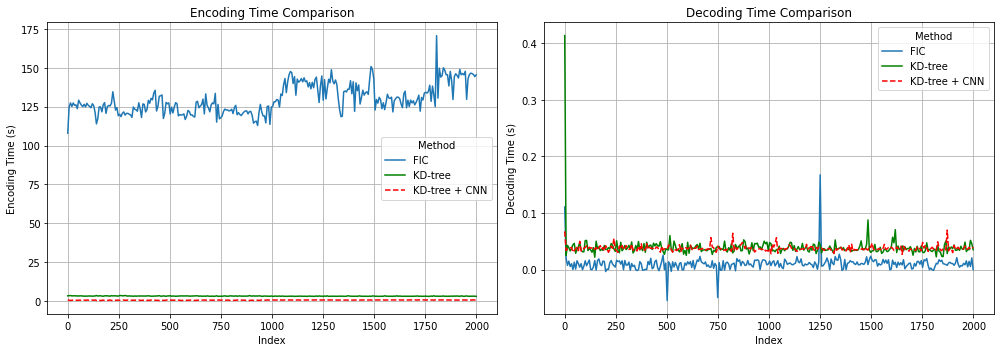

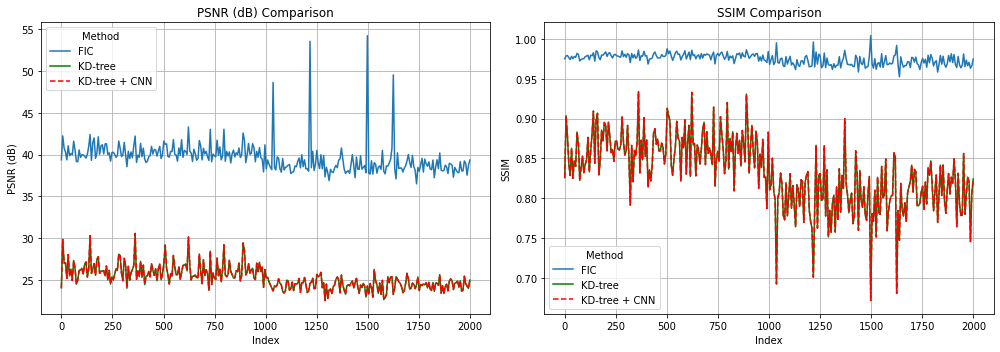

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

# Load CSV files
traditional_df = pd.read_csv(traditional_csvFile)
kdTree_df = pd.read_csv(kdTree_csvFile)
proposed_df = pd.read_csv(enhanced_csvFile)

# Assign method labels
traditional_df["Method"] = "FIC"
kdTree_df["Method"] = "KD-tree"
proposed_df["Method"] = "KD-tree + CNN"

# Combine all into one DataFrame
df_combined = pd.concat([traditional_df, kdTree_df, proposed_df])

# -------------------------------
# Plot 1: Encoding & Decoding Time
# -------------------------------
fig1, axes1 = plt.subplots(1, 2, figsize=(14, 5))

time_metrics = ["Encoding Time (s)", "Decoding Time (s)"]
time_titles = ["Encoding Time Comparison", "Decoding Time Comparison"]

for i, metric in enumerate(time_metrics):
    ax = axes1[i]
    for method in df_combined["Method"].unique():
        method_data = df_combined[df_combined["Method"] == method]
        y = method_data[metric].dropna()
        x = np.arange(len(y))

        line_kwargs = {"label": method}
        if method == "KD-tree + CNN":
            line_kwargs.update({"linestyle": "--", "color": "red"})
        elif method == "KD-tree":
            line_kwargs.update({"color": "green"})

        if len(y) > 3 and len(np.unique(x)) > 3:
            try:
                x_new = np.linspace(x.min(), x.max(), 300)
                spline = make_interp_spline(x, y, k=3)
                y_smooth = spline(x_new)
                ax.plot(x_new, y_smooth, **line_kwargs)
            except Exception as e:
                print(f"[Warning] Spline failed for {method} - {metric}: {e}")
                ax.plot(x, y, **line_kwargs)
        else:
            ax.plot(x, y, **line_kwargs)

    ax.set_title(time_titles[i])
    ax.set_xlabel("Index")
    ax.set_ylabel(metric)
    ax.grid(True)
    ax.legend(title="Method", loc='best')

plt.tight_layout()
plt.show()

# -------------------------------
# Plot 2: PSNR & SSIM
# -------------------------------
fig2, axes2 = plt.subplots(1, 2, figsize=(14, 5))

quality_metrics = ["PSNR (dB)", "SSIM"]
quality_titles = ["PSNR (dB) Comparison", "SSIM Comparison"]

for i, metric in enumerate(quality_metrics):
    ax = axes2[i]
    for method in df_combined["Method"].unique():
        method_data = df_combined[df_combined["Method"] == method]
        y = method_data[metric].dropna()
        x = np.arange(len(y))

        line_kwargs = {"label": method}
        if method == "KD-tree + CNN":
            line_kwargs.update({"linestyle": "--", "color": "red"})
        elif method == "KD-tree":
            line_kwargs.update({"color": "green"})

        if len(y) > 3 and len(np.unique(x)) > 3:
            try:
                x_new = np.linspace(x.min(), x.max(), 300)
                spline = make_interp_spline(x, y, k=3)
                y_smooth = spline(x_new)
                ax.plot(x_new, y_smooth, **line_kwargs)
            except Exception as e:
                print(f"[Warning] Spline failed for {method} - {metric}: {e}")
                ax.plot(x, y, **line_kwargs)
        else:
            ax.plot(x, y, **line_kwargs)

    ax.set_title(quality_titles[i])
    ax.set_xlabel("Index")
    ax.set_ylabel(metric)
    ax.grid(True)
    ax.legend(title="Method", loc='best')

plt.tight_layout()
plt.show()


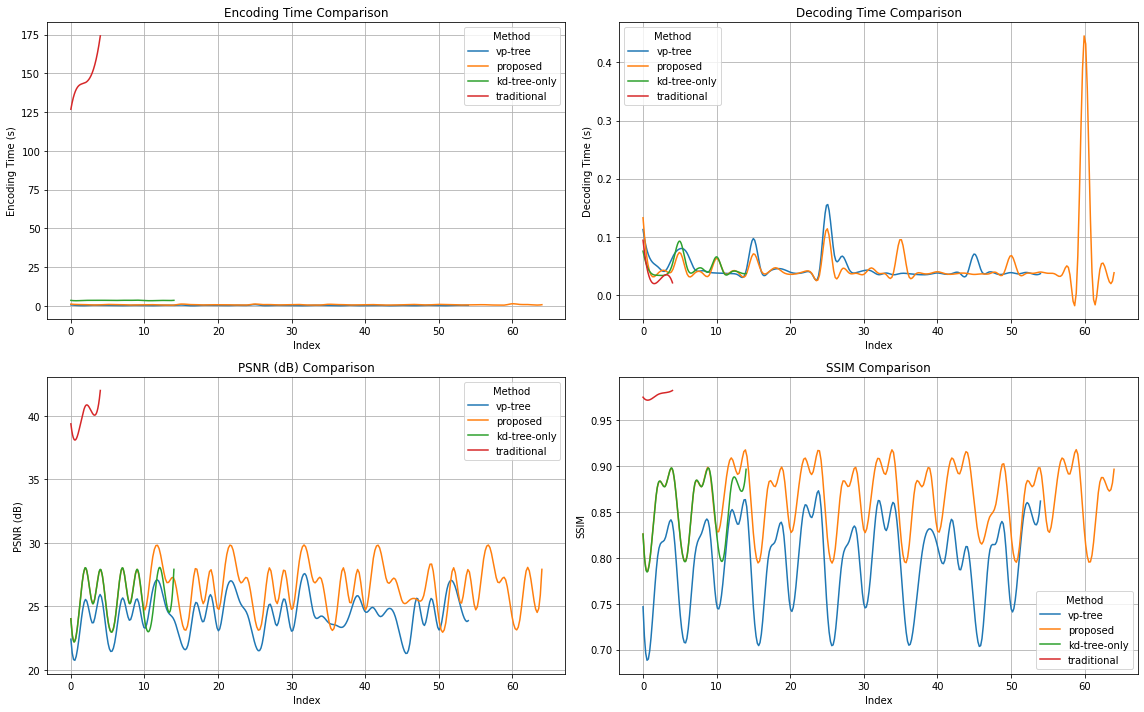

In [4]:
# dynamic run
df = pd.read_csv("csv/singleRun_CSV.csv")

# Create 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 10), sharex=False)

# Define metrics and titles
metrics = ["Encoding Time (s)", "Decoding Time (s)", "PSNR (dB)", "SSIM"]
titles = [
    "Encoding Time Comparison",
    "Decoding Time Comparison",
    "PSNR (dB) Comparison",
    "SSIM Comparison"
]

# Plot each metric
for i, metric in enumerate(metrics):
    ax = axes[i // 2, i % 2]
    for method in df["Method"].unique():
        method_data = df[df["Method"] == method]
        y = method_data[metric].dropna().values
        x = np.arange(len(y))

        line_kwargs = {"label": method}
        if method == "Proposed":
            line_kwargs["linestyle"] = "--"

        if len(y) > 3 and len(np.unique(x)) > 3:
            try:
                x_new = np.linspace(x.min(), x.max(), 300)
                spline = make_interp_spline(x, y, k=3)
                y_smooth = spline(x_new)
                ax.plot(x_new, y_smooth, **line_kwargs)
            except Exception as e:
                print(f"[Warning] Spline failed for {method} - {metric}: {e}")
                ax.plot(x, y, **line_kwargs)
        else:
            ax.plot(x, y, **line_kwargs)

    ax.set_title(titles[i])
    ax.set_xlabel("Index")
    ax.set_ylabel(metric)
    ax.grid(True)
    ax.legend(title="Method", loc='best')

# Final layout adjustment
plt.tight_layout()
plt.show()

In [5]:
# (hindi to kasali) getting the names of multi tested data
df = pd.read_csv(multiTest_csvFile)

# Extract the unique values from the "Original Image" column
unique_original_images = df["Original Image"].unique().tolist()

# Initialize the lists for each category
glioma_Largest = []
glioma_Mid = []
glioma_Smallest = []
pituitary_Largest = []
pituitary_Mid = []
pituitary_Smallest = []

# Distribute the unique images into the different lists
for i in range(0, len(unique_original_images), 5):
    # Get a chunk of 5 images
    chunk = unique_original_images[i:i+5]
    
    # Assign each chunk to a corresponding list
    if len(glioma_Largest) < 5:
        glioma_Largest.extend(chunk)
    elif len(glioma_Mid) < 5:
        glioma_Mid.extend(chunk)
    elif len(glioma_Smallest) < 5:
        glioma_Smallest.extend(chunk)
    elif len(pituitary_Largest) < 5:
        pituitary_Largest.extend(chunk)
    elif len(pituitary_Mid) < 5:
        pituitary_Mid.extend(chunk)
    elif len(pituitary_Smallest) < 5:
        pituitary_Smallest.extend(chunk)

# Print the lists to check
print("Glioma Largest:", glioma_Largest)
print("Glioma Mid:", glioma_Mid)
print("Glioma Smallest:", glioma_Smallest)
print("Pituitary Largest:", pituitary_Largest)
print("Pituitary Mid:", pituitary_Mid)
print("Pituitary Smallest:", pituitary_Smallest)

Glioma Largest: ['glioma_0132.jpg', 'glioma_0990.jpg', 'glioma_0322.jpg', 'glioma_0296.jpg', 'glioma_0102.jpg']
Glioma Mid: ['glioma_0840.jpg', 'glioma_0557.jpg', 'glioma_0386.jpg', 'glioma_0769.jpg', 'glioma_0159.jpg']
Glioma Smallest: ['glioma_0934.jpg', 'glioma_0171.jpg', 'glioma_0111.jpg', 'glioma_0918.jpg', 'glioma_0558.jpg']
Pituitary Largest: ['pituitary_0048.jpg', 'pituitary_0681.jpg', 'pituitary_0287.jpg', 'pituitary_0798.jpg', 'pituitary_0598.jpg']
Pituitary Mid: ['pituitary_0274.jpg', 'pituitary_0873.jpg', 'pituitary_0971.jpg', 'pituitary_0816.jpg', 'pituitary_0217.jpg']
Pituitary Smallest: ['pituitary_0106.jpg', 'pituitary_0249.jpg', 'pituitary_0498.jpg', 'pituitary_0218.jpg', 'pituitary_0499.jpg']


In [6]:
# distribution of data base on size
df = pd.read_csv(enhanced_csvFile)

# Extract category from filename
df['Category'] = df['Original Image'].apply(
    lambda x: 'Glioma' if 'glioma' in x.lower() else 'Pituitary' if 'pituitary' in x.lower() else 'Unknown'
)

# Define size bins and labels
bins = [0, 30, 60, 90, 120, float('inf')]
labels = ['< 30 KB', '30-60 KB', '60-90 KB', '90-120 KB', '> 120 KB']

# Categorize image sizes
df['Size Category'] = pd.cut(df['Original Image Size (KB)'], bins=bins, labels=labels, right=False)

# Group by Category and Size Category
grouped = df.groupby(['Category', 'Size Category']).size().unstack(fill_value=0)

# Convert to percentages
percentages = grouped.div(grouped.sum(axis=1), axis=0) * 100
percentages = percentages.round(2)

# Display the result
print("\nPercentage of Images by Category and Size Range:")
print(percentages)


Percentage of Images by Category and Size Range:
Size Category  < 30 KB  30-60 KB  60-90 KB  90-120 KB  > 120 KB
Category                                                       
Glioma            29.0      71.0       0.0        0.0       0.0
Pituitary          1.1      97.9       0.4        0.1       0.5


C:\Users\Tristan\AppData\Local\Temp\ipykernel_16672\453824845.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(['Category', 'Size Category']).size().unstack(fill_value=0)



CNN Training Summary Table:

 Epoch  Training Loss  Training Time (s)
     1       4.448427            79.0690
     2       3.447695            81.8670
     3       3.366121            83.0977
     4       3.301909            84.4567
     5       3.264943            82.7571
     6       3.242062            79.0781
     7       3.226956            78.7745
     8       3.216202            78.7636
     9       3.211485            78.6790
    10       3.206481            78.4997


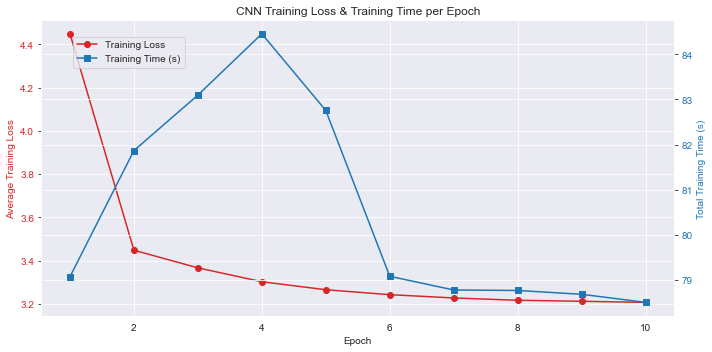

In [7]:
# CNN MODEL TRAINING TIME & ACCURACY
columns_to_display = ["Epoch", 
                      "Batch", 
                      "Training Loss", 
                      "Training Time (s)"]

try:
    # Read CSV file
    df_cnn = pd.read_csv(cnnModel_csvFile)[columns_to_display]

    # Compute the average Training Loss and total Training Time per epoch
    df_summary = df_cnn.groupby("Epoch").agg({
        "Training Loss": "mean",  # Average training loss per epoch
        "Training Time (s)": "sum"  # Total training time per epoch
    }).reset_index()

    # Display as a formatted table without tabulate
    print("\nCNN Training Summary Table:\n")
    print(df_summary.to_string(index=False))  # Clean table output

    # Prepare data for plotting
    x = df_summary["Epoch"]
    y_loss = df_summary["Training Loss"]
    y_time = df_summary["Training Time (s)"]

    # Set plot style
    sns.set_style("darkgrid")

    # Create figure and axes
    fig, ax1 = plt.subplots(figsize=(10, 5))

    # Plot Training Loss
    color1 = "tab:red"
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Average Training Loss", color=color1)
    line1, = ax1.plot(x, y_loss, marker='o', color=color1, label="Training Loss")
    ax1.tick_params(axis="y", labelcolor=color1)

    # Second y-axis for Training Time
    ax2 = ax1.twinx()
    color2 = "tab:blue"
    ax2.set_ylabel("Total Training Time (s)", color=color2)
    line2, = ax2.plot(x, y_time, marker='s', color=color2, label="Training Time (s)")
    ax2.tick_params(axis="y", labelcolor=color2)

    # Add legend and title
    fig.legend(handles=[line1, line2], loc="upper left", bbox_to_anchor=(0.1, 0.9))
    plt.title("CNN Training Loss & Training Time per Epoch")
    fig.tight_layout()
    plt.show()

except FileNotFoundError as e:
    print(f"Error: {e}")


In [8]:
# Cross-Dataset Generalization Analysis
columns_to_display = ["Original Image", 
                      "Encoding Time (s)", 
                      "Decoding Time (s)", 
                      "PSNR (dB)", 
                      "SSIM"]

try:
    # Read the CSV file
    df = pd.read_csv(enhanced_csvFile)[columns_to_display]

    # Extract the condition (Glioma or Pituitary) from the filename
    df["Dataset"] = df["Original Image"].apply(lambda x: 
        "Glioma" if "glioma" in x.lower() else 
        "Pituitary" if "pituitary" in x.lower() else "Unknown"
    )

    # Compute the averages for each category
    df_summary = df.groupby("Dataset").agg({
        "Encoding Time (s)": "mean",
        "Decoding Time (s)": "mean",
        "PSNR (dB)": "mean",
        "SSIM": "mean"
    }).reset_index()

    print("\nMRI Image Compression Summary:\n")
    print(df_summary.to_string(index=False))  # Clean table output

    # Filter data into two groups
    glioma_data = df[df["Dataset"] == "Glioma"]
    pituitary_data = df[df["Dataset"] == "Pituitary"]

    # Store t-test results in a list
    ttest_results = []

    # Perform t-tests
    metrics_to_test = ["Encoding Time (s)", "Decoding Time (s)", "PSNR (dB)", "SSIM"]
    for metric in metrics_to_test:
        t_stat, p_value = ttest_ind(glioma_data[metric], pituitary_data[metric], equal_var=False)
        result = {
            "Metric": metric,
            "T-Statistic": round(t_stat, 4),
            "P-Value": round(p_value, 4),
            "Significant?": "Yes" if p_value < 0.05 else "No"
        }
        ttest_results.append(result)

    # Create and display a table of t-test results
    ttest_df = pd.DataFrame(ttest_results)

    print("\nT-Test Results (Glioma vs Pituitary):\n")
    print(ttest_df.to_string(index=False))

except Exception as e:
    print("An error occurred:", e)


MRI Image Compression Summary:

  Dataset  Encoding Time (s)  Decoding Time (s)  PSNR (dB)     SSIM
   Glioma           0.621558           0.037335  26.275318 0.864595
Pituitary           0.767804           0.037471  24.414191 0.805749

T-Test Results (Glioma vs Pituitary):

           Metric  T-Statistic  P-Value Significant?
Encoding Time (s)     -38.6704   0.0000          Yes
Decoding Time (s)      -0.6209   0.5347           No
        PSNR (dB)      35.8166   0.0000          Yes
             SSIM      42.2377   0.0000          Yes


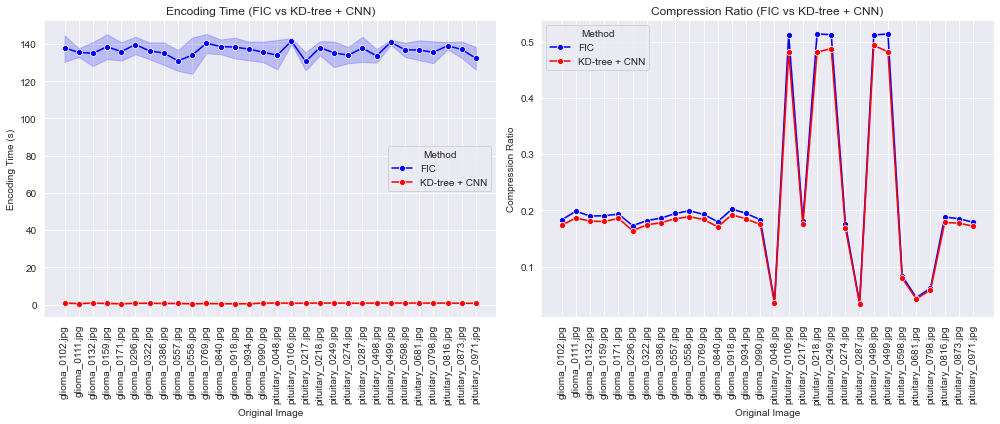

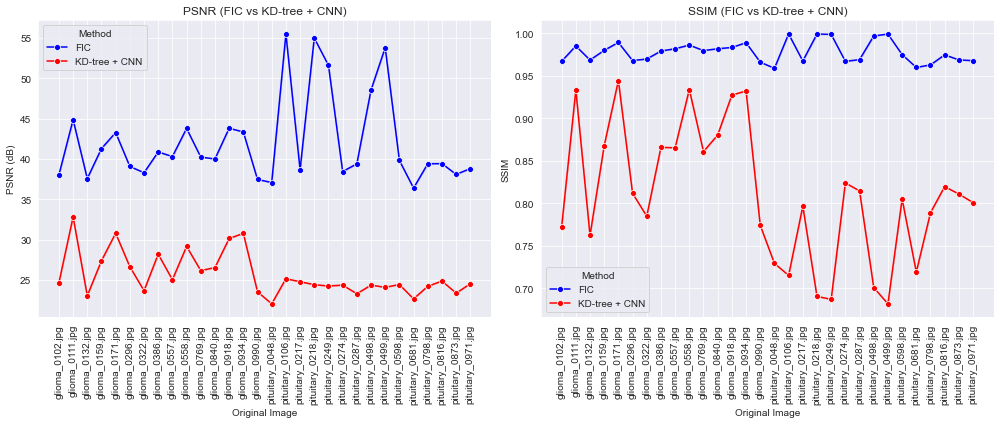

Average Data for Glioma Largest (FIC) method:


C:\Users\Tristan\AppData\Local\Temp\ipykernel_16672\1193372505.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["Original Image"] = pd.Categorical(df_filtered["Original Image"], categories=image_list, ordered=True)


,Original Image,Original Image Size (KB),Compressed Image Size (KB),Compression Ratio,Build Tree Time (ms),Nearest Search Time (ms),CNN Inference Time (ms),Encoding Time (s),Decoding Time (s),PSNR (dB),SSIM,Blocks (blocks/s)
0,glioma_0132.jpg,53.32,10.12,0.1898,0.0,135.0190,0.0,135.0280,0.1016,37.5841,0.9685,0.0
1,glioma_0990.jpg,53.23,9.75,0.1832,0.0,135.5801,0.0,135.5899,0.0117,37.4709,0.9660,0.0
2,glioma_0322.jpg,52.54,9.55,0.1818,0.0,136.2712,0.0,136.2808,0.0107,38.3082,0.9697,0.0
3,glioma_0296.jpg,52.20,9.01,0.1726,0.0,139.6991,0.0,139.7079,0.0092,39.0860,0.9679,0.0
4,glioma_0102.jpg,50.99,9.34,0.1832,0.0,137.9233,0.0,137.9323,0.0093,38.0360,0.9670,0.0




Average Data for Glioma Mid (FIC) method:


C:\Users\Tristan\AppData\Local\Temp\ipykernel_16672\1193372505.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["Original Image"] = pd.Categorical(df_filtered["Original Image"], categories=image_list, ordered=True)


,Original Image,Original Image Size (KB),Compressed Image Size (KB),Compression Ratio,Build Tree Time (ms),Nearest Search Time (ms),CNN Inference Time (ms),Encoding Time (s),Decoding Time (s),PSNR (dB),SSIM,Blocks (blocks/s)
0,glioma_0840.jpg,34.00,6.11,0.1797,0.0,138.6384,0.0,138.6485,0.0109,40.0174,0.9818,0.0
1,glioma_0557.jpg,34.01,6.61,0.1944,0.0,130.9580,0.0,130.9675,0.0119,40.3121,0.9818,0.0
2,glioma_0386.jpg,34.02,6.33,0.1861,0.0,135.1680,0.0,135.1774,0.0100,40.8862,0.9791,0.0
3,glioma_0769.jpg,34.04,6.56,0.1927,0.0,140.4371,0.0,140.4465,0.0096,40.2426,0.9796,0.0
4,glioma_0159.jpg,34.04,6.48,0.1904,0.0,138.5489,0.0,138.5597,0.0110,41.3051,0.9799,0.0




Average Data for Glioma Smallest (FIC) method:


C:\Users\Tristan\AppData\Local\Temp\ipykernel_16672\1193372505.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["Original Image"] = pd.Categorical(df_filtered["Original Image"], categories=image_list, ordered=True)


,Original Image,Original Image Size (KB),Compressed Image Size (KB),Compression Ratio,Build Tree Time (ms),Nearest Search Time (ms),CNN Inference Time (ms),Encoding Time (s),Decoding Time (s),PSNR (dB),SSIM,Blocks (blocks/s)
0,glioma_0934.jpg,19.43,3.78,0.1945,0.0,137.2718,0.0,137.2827,0.0116,43.3651,0.9889,0.0
1,glioma_0171.jpg,19.81,3.83,0.1933,0.0,135.9312,0.0,135.9415,0.0104,43.2907,0.9892,0.0
2,glioma_0111.jpg,19.91,3.95,0.1984,0.0,135.4931,0.0,135.5039,0.0137,44.8870,0.9851,0.0
3,glioma_0918.jpg,19.93,4.03,0.2022,0.0,138.3305,0.0,138.3412,0.0122,43.8200,0.9833,0.0
4,glioma_0558.jpg,20.02,3.99,0.1993,0.0,133.9865,0.0,133.9962,0.0108,43.7987,0.9861,0.0




Average Data for Pituitary Largest (FIC) method:


C:\Users\Tristan\AppData\Local\Temp\ipykernel_16672\1193372505.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["Original Image"] = pd.Categorical(df_filtered["Original Image"], categories=image_list, ordered=True)


,Original Image,Original Image Size (KB),Compressed Image Size (KB),Compression Ratio,Build Tree Time (ms),Nearest Search Time (ms),CNN Inference Time (ms),Encoding Time (s),Decoding Time (s),PSNR (dB),SSIM,Blocks (blocks/s)
0,pituitary_0048.jpg,328.59,12.10,0.0368,0.0,134.0148,0.0,134.0241,0.0107,37.0943,0.9588,0.0
1,pituitary_0681.jpg,266.28,11.91,0.0447,0.0,136.7472,0.0,136.7567,0.0086,36.4053,0.9598,0.0
2,pituitary_0287.jpg,236.31,8.25,0.0349,0.0,137.8149,0.0,137.8248,0.0102,39.4102,0.9690,0.0
3,pituitary_0798.jpg,147.91,9.13,0.0617,0.0,135.5664,0.0,135.5758,0.0109,39.4198,0.9628,0.0
4,pituitary_0598.jpg,124.30,10.38,0.0835,0.0,136.9073,0.0,136.9175,0.0110,39.8305,0.9749,0.0




Average Data for Pituitary Mid (FIC) method:


C:\Users\Tristan\AppData\Local\Temp\ipykernel_16672\1193372505.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["Original Image"] = pd.Categorical(df_filtered["Original Image"], categories=image_list, ordered=True)


,Original Image,Original Image Size (KB),Compressed Image Size (KB),Compression Ratio,Build Tree Time (ms),Nearest Search Time (ms),CNN Inference Time (ms),Encoding Time (s),Decoding Time (s),PSNR (dB),SSIM,Blocks (blocks/s)
0,pituitary_0274.jpg,48.93,8.58,0.1754,0.0,134.0092,0.0,134.0187,0.0098,38.4556,0.9670,0.0
1,pituitary_0873.jpg,48.93,9.06,0.1852,0.0,137.1079,0.0,137.1166,0.0085,38.1015,0.9687,0.0
2,pituitary_0971.jpg,48.95,8.75,0.1788,0.0,132.3245,0.0,132.3346,0.0111,38.8194,0.9678,0.0
3,pituitary_0816.jpg,48.95,9.21,0.1882,0.0,139.0308,0.0,139.0406,0.0104,39.4398,0.9746,0.0
4,pituitary_0217.jpg,48.97,8.88,0.1813,0.0,130.6284,0.0,130.6376,0.0107,38.6875,0.9674,0.0




Average Data for Pituitary Smallest (FIC) method:


C:\Users\Tristan\AppData\Local\Temp\ipykernel_16672\1193372505.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["Original Image"] = pd.Categorical(df_filtered["Original Image"], categories=image_list, ordered=True)


,Original Image,Original Image Size (KB),Compressed Image Size (KB),Compression Ratio,Build Tree Time (ms),Nearest Search Time (ms),CNN Inference Time (ms),Encoding Time (s),Decoding Time (s),PSNR (dB),SSIM,Blocks (blocks/s)
0,pituitary_0106.jpg,20.61,10.56,0.5124,0.0,141.5696,0.0,141.5798,0.0113,55.5132,0.9992,0.0
1,pituitary_0249.jpg,20.92,10.72,0.5124,0.0,135.2477,0.0,135.2588,0.0129,51.6280,0.9987,0.0
2,pituitary_0498.jpg,20.98,10.74,0.5119,0.0,133.6362,0.0,133.6454,0.0095,48.5595,0.9968,0.0
3,pituitary_0218.jpg,21.46,11.02,0.5135,0.0,138.0835,0.0,138.0938,0.0106,55.0052,0.9991,0.0
4,pituitary_0499.jpg,21.79,11.19,0.5135,0.0,140.9575,0.0,140.9678,0.0094,53.8175,0.9991,0.0


In [9]:
# AVERAGE OF VALUES FOR TRADITIONAL
df = pd.read_csv(multiTest_csvFile)

# Apply the conversion function to the "Compression Ratio" column
df["Compression Ratio"] = df["Compressed Image Size (KB)"] / df["Original Image Size (KB)"]

# Rename method labels
df["Method"] = df["Method"].replace({
    "traditional": "FIC",
    "proposed": "KD-tree + CNN"
})

# Filter only traditional and proposed methods
df_filtered = df[df["Method"].isin(["FIC", "KD-tree + CNN"])]
df_filtered = df_filtered.sort_values(by="Original Image")


# First plot: Encoding Time and Compression Ratio comparison for traditional vs proposed
# Set figure size
palette = {"FIC": "blue", "KD-tree": "green", "KD-tree + CNN": "red"}
plt.figure(figsize=(14, 6))

# Plot 1: Encoding Time
plt.subplot(1, 2, 1)
sns.lineplot(
    data=df_filtered,
    x="Original Image",
    y="Encoding Time (s)",
    hue="Method",
    marker="o",
    palette=palette
)
plt.xticks(rotation=90)
plt.title("Encoding Time (FIC vs KD-tree + CNN)")
plt.ylabel("Encoding Time (s)")
plt.xlabel("Original Image")
plt.grid(True)

# Plot 2: Compression Ratio
plt.subplot(1, 2, 2)
sns.lineplot(
    data=df_filtered,
    x="Original Image",
    y="Compression Ratio",
    hue="Method",
    marker="o",
    palette=palette
)
plt.xticks(rotation=90)
plt.title("Compression Ratio (FIC vs KD-tree + CNN)")
plt.ylabel("Compression Ratio")
plt.xlabel("Original Image")
plt.grid(True)

plt.tight_layout()
plt.show()


# Second plot: PSNR and SSIM comparison for traditional vs proposed
# Set figure size
plt.figure(figsize=(14, 6))

# Plot 1: PSNR
plt.subplot(1, 2, 1)
sns.lineplot(
    data=df_filtered,
    x="Original Image",
    y="PSNR (dB)",
    hue="Method",
    marker="o",
    palette=palette
)
plt.xticks(rotation=90)
plt.title("PSNR (FIC vs KD-tree + CNN)")
plt.ylabel("PSNR (dB)")
plt.xlabel("Original Image")
plt.grid(True)

# Plot 2: SSIM
plt.subplot(1, 2, 2)
sns.lineplot(
    data=df_filtered,
    x="Original Image",
    y="SSIM",
    hue="Method",
    marker="o",
    palette=palette
)
plt.xticks(rotation=90)
plt.title("SSIM (FIC vs KD-tree + CNN)")
plt.ylabel("SSIM")
plt.xlabel("Original Image")
plt.grid(True)

plt.tight_layout()
plt.show()


# Group by "Original Image" and calculate the mean for each column for traditional method
df_traditional = df[df["Method"] == "FIC"].groupby("Original Image").agg({
    "Original Image Size (KB)": "mean",
    "Compressed Image Size (KB)": "mean",
    "Compression Ratio": "mean",
    "Build Tree Time (ms)": "mean",
    "Nearest Search Time (ms)": "mean",
    "CNN Inference Time (ms)": "mean",
    "Encoding Time (s)": "mean",
    "Decoding Time (s)": "mean",
    "PSNR (dB)": "mean",
    "SSIM": "mean",
    "Blocks (blocks/s)": "mean"
}).reset_index()

# Function to display the averaged data while maintaining order
def display_avg_data(image_list, method_df, method_name):
    # Filter the DataFrame for the given "Original Image" values
    df_filtered = method_df[method_df["Original Image"].isin(image_list)]
    
    # Reorder the rows based on the image_list order
    df_filtered["Original Image"] = pd.Categorical(df_filtered["Original Image"], categories=image_list, ordered=True)
    df_filtered = df_filtered.sort_values("Original Image").reset_index(drop=True)

    # Round numeric columns to 4 decimal places
    df_filtered = df_filtered.round({
        "Original Image Size (KB)": 4,
        "Compressed Image Size (KB)": 4,
        "Compression Ratio": 4,
        "Build Tree Time (ms)": 4,
        "Nearest Search Time (ms)": 4,
        "CNN Inference Time (ms)": 4,
        "Encoding Time (s)": 4,
        "Decoding Time (s)": 4,
        "PSNR (dB)": 4,
        "SSIM": 4,
        "Blocks (blocks/s)": 4
    })
    
    # Display the filtered and ordered data
    print(f"Average Data for {method_name} method:")
    display(df_filtered[[ 
        "Original Image", "Original Image Size (KB)", "Compressed Image Size (KB)", 
        "Compression Ratio", "Build Tree Time (ms)", "Nearest Search Time (ms)", 
        "CNN Inference Time (ms)", "Encoding Time (s)", "Decoding Time (s)", 
        "PSNR (dB)", "SSIM", "Blocks (blocks/s)"
    ]])
    print("\n")

# Now, let's display the averaged data for each category using the traditional method
for category, image_list in zip(
    ["Glioma Largest", "Glioma Mid", "Glioma Smallest", 
     "Pituitary Largest", "Pituitary Mid", "Pituitary Smallest"],
    [glioma_Largest, glioma_Mid, glioma_Smallest, 
     pituitary_Largest, pituitary_Mid, pituitary_Smallest]):

    # Display averaged data for the traditional method
    display_avg_data(image_list, df_traditional, f"{category} (FIC)")

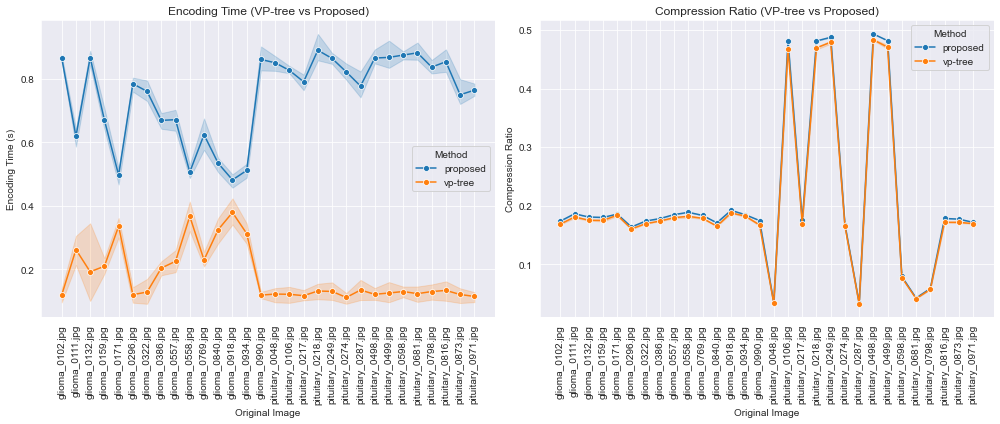

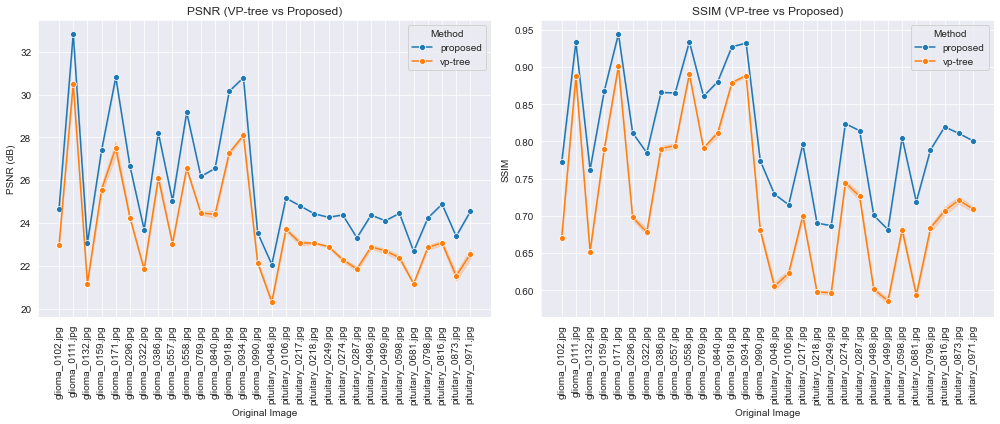

Average Data for Glioma Largest (VP-tree) method:


C:\Users\Tristan\AppData\Local\Temp\ipykernel_16672\2371830875.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["Original Image"] = pd.Categorical(df_filtered["Original Image"], categories=image_list, ordered=True)


,Original Image,Original Image Size (KB),Compressed Image Size (KB),Compression Ratio,Build Tree Time (ms),Nearest Search Time (ms),CNN Inference Time (ms),Encoding Time (s),Decoding Time (s),PSNR (dB),SSIM,Blocks (blocks/s)
0,glioma_0132.jpg,53.32,9.350,0.1754,15.6440,0.0453,125.5334,0.1920,0.0506,21.1693,0.6522,20626.1560
1,glioma_0990.jpg,53.23,8.904,0.1673,16.7382,0.0463,51.0242,0.1183,0.0439,22.1508,0.6807,20932.5416
2,glioma_0322.jpg,52.54,8.902,0.1694,17.3772,0.0447,62.5752,0.1281,0.0382,21.8274,0.6783,21455.2014
3,glioma_0296.jpg,52.20,8.376,0.1605,16.0591,0.0465,44.4479,0.1196,0.0449,24.2495,0.6981,20591.0921
4,glioma_0102.jpg,50.99,8.604,0.1687,17.2796,0.0478,45.6955,0.1187,0.0384,22.9556,0.6703,19755.8721




Average Data for Glioma Mid (VP-tree) method:


C:\Users\Tristan\AppData\Local\Temp\ipykernel_16672\2371830875.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["Original Image"] = pd.Categorical(df_filtered["Original Image"], categories=image_list, ordered=True)


,Original Image,Original Image Size (KB),Compressed Image Size (KB),Compression Ratio,Build Tree Time (ms),Nearest Search Time (ms),CNN Inference Time (ms),Encoding Time (s),Decoding Time (s),PSNR (dB),SSIM,Blocks (blocks/s)
0,glioma_0840.jpg,34.00,5.618,0.1652,17.3925,0.2477,46.2093,0.3249,0.0417,24.4026,0.8114,4033.7610
1,glioma_0557.jpg,34.01,6.114,0.1798,17.6577,0.1525,44.2986,0.2250,0.0381,23.0342,0.7945,6484.7885
2,glioma_0386.jpg,34.02,5.916,0.1739,17.1333,0.1366,45.3582,0.2037,0.0491,26.1063,0.7905,7183.9829
3,glioma_0769.jpg,34.04,6.078,0.1786,17.6975,0.1590,45.6375,0.2294,0.0473,24.4623,0.7911,6152.0051
4,glioma_0159.jpg,34.04,5.952,0.1749,16.3953,0.1380,44.5808,0.2093,0.0416,25.5615,0.7896,7130.2951




Average Data for Glioma Smallest (VP-tree) method:


C:\Users\Tristan\AppData\Local\Temp\ipykernel_16672\2371830875.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["Original Image"] = pd.Categorical(df_filtered["Original Image"], categories=image_list, ordered=True)


,Original Image,Original Image Size (KB),Compressed Image Size (KB),Compression Ratio,Build Tree Time (ms),Nearest Search Time (ms),CNN Inference Time (ms),Encoding Time (s),Decoding Time (s),PSNR (dB),SSIM,Blocks (blocks/s)
0,glioma_0934.jpg,19.43,3.542,0.1823,16.7741,0.2368,44.2341,0.3125,0.0403,28.0891,0.8885,4194.7481
1,glioma_0171.jpg,19.81,3.644,0.1839,16.6509,0.2665,43.6742,0.3357,0.0448,27.5044,0.9012,3714.1610
2,glioma_0111.jpg,19.91,3.600,0.1808,18.0623,0.1864,47.4201,0.2619,0.0410,30.5082,0.8873,5430.8438
3,glioma_0918.jpg,19.93,3.742,0.1878,21.8701,0.2975,46.7938,0.3790,0.0451,27.2727,0.8790,3342.4371
4,glioma_0558.jpg,20.02,3.642,0.1819,17.4436,0.2850,51.5425,0.3667,0.0425,26.5519,0.8906,3509.0469




Average Data for Pituitary Largest (VP-tree) method:


C:\Users\Tristan\AppData\Local\Temp\ipykernel_16672\2371830875.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["Original Image"] = pd.Categorical(df_filtered["Original Image"], categories=image_list, ordered=True)


,Original Image,Original Image Size (KB),Compressed Image Size (KB),Compression Ratio,Build Tree Time (ms),Nearest Search Time (ms),CNN Inference Time (ms),Encoding Time (s),Decoding Time (s),PSNR (dB),SSIM,Blocks (blocks/s)
0,pituitary_0048.jpg,328.59,11.096,0.0338,16.0579,0.0457,50.3536,0.1216,0.0440,20.3075,0.6056,20856.9345
1,pituitary_0681.jpg,266.28,11.040,0.0415,15.0983,0.0516,51.3277,0.1229,0.0420,21.1563,0.5939,19306.6366
2,pituitary_0287.jpg,236.31,7.736,0.0327,17.9508,0.0565,54.3911,0.1343,0.0487,21.8487,0.7264,17592.8115
3,pituitary_0798.jpg,147.91,8.456,0.0572,15.9179,0.0557,53.3209,0.1296,0.0431,22.8559,0.6837,17836.4389
4,pituitary_0598.jpg,124.30,9.624,0.0774,17.9952,0.0501,54.4275,0.1297,0.0362,22.3761,0.6817,19134.2542




Average Data for Pituitary Mid (VP-tree) method:


C:\Users\Tristan\AppData\Local\Temp\ipykernel_16672\2371830875.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["Original Image"] = pd.Categorical(df_filtered["Original Image"], categories=image_list, ordered=True)


,Original Image,Original Image Size (KB),Compressed Image Size (KB),Compression Ratio,Build Tree Time (ms),Nearest Search Time (ms),CNN Inference Time (ms),Encoding Time (s),Decoding Time (s),PSNR (dB),SSIM,Blocks (blocks/s)
0,pituitary_0274.jpg,48.93,8.094,0.1654,14.3005,0.0468,52.3834,0.1110,0.0468,22.2883,0.7447,20592.2997
1,pituitary_0873.jpg,48.93,8.402,0.1717,17.5777,0.0461,52.5360,0.1203,0.0429,21.5201,0.7213,20781.7211
2,pituitary_0971.jpg,48.95,8.298,0.1695,16.6937,0.0458,52.7410,0.1141,0.0403,22.5447,0.7093,20859.8260
3,pituitary_0816.jpg,48.95,8.408,0.1718,18.8455,0.0534,53.0545,0.1330,0.0410,23.0670,0.7069,18591.2075
4,pituitary_0217.jpg,48.97,8.310,0.1697,15.7969,0.0449,52.9503,0.1166,0.0382,23.0637,0.7003,21296.6764




Average Data for Pituitary Smallest (VP-tree) method:


C:\Users\Tristan\AppData\Local\Temp\ipykernel_16672\2371830875.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["Original Image"] = pd.Categorical(df_filtered["Original Image"], categories=image_list, ordered=True)


,Original Image,Original Image Size (KB),Compressed Image Size (KB),Compression Ratio,Build Tree Time (ms),Nearest Search Time (ms),CNN Inference Time (ms),Encoding Time (s),Decoding Time (s),PSNR (dB),SSIM,Blocks (blocks/s)
0,pituitary_0106.jpg,20.61,9.644,0.4679,19.2891,0.0461,53.9892,0.1209,0.0411,23.6996,0.6231,20838.7847
1,pituitary_0249.jpg,20.92,10.024,0.4792,18.9631,0.0498,55.1534,0.1299,0.0388,22.8928,0.5969,19828.5727
2,pituitary_0498.jpg,20.98,10.140,0.4833,15.0204,0.0482,53.0052,0.1208,0.0375,22.8795,0.6017,20377.8279
3,pituitary_0218.jpg,21.46,10.076,0.4695,15.3282,0.0542,52.3511,0.1313,0.0434,23.0630,0.5979,17960.8946
4,pituitary_0499.jpg,21.79,10.260,0.4709,16.7975,0.0500,52.0993,0.1250,0.0453,22.6997,0.5859,19855.7629


In [10]:
# AVERAGE OF VALUES FOR VP-TREE + CNN
df = pd.read_csv(multiTest_csvFile)

# Apply the conversion function to the "Compression Ratio" column
df["Compression Ratio"] = df["Compressed Image Size (KB)"] / df["Original Image Size (KB)"]

# Filter only vp-tree and proposed methods
df_filtered = df[df["Method"].isin(["vp-tree", "proposed"])]
df_filtered = df_filtered.sort_values(by="Original Image")


# First plot: Encoding Time and Compression Ratio comparison for vp-tree vs proposed
# Set figure size
plt.figure(figsize=(14, 6))

# Plot 1: Encoding Time
plt.subplot(1, 2, 1)
sns.lineplot(
    data=df_filtered,
    x="Original Image",
    y="Encoding Time (s)",
    hue="Method",
    marker="o"
)
plt.xticks(rotation=90)
plt.title("Encoding Time (VP-tree vs Proposed)")
plt.ylabel("Encoding Time (s)")
plt.xlabel("Original Image")
plt.grid(True)

# Plot 2: Compression Ratio
plt.subplot(1, 2, 2)
sns.lineplot(
    data=df_filtered,
    x="Original Image",
    y="Compression Ratio",
    hue="Method",
    marker="o"
)
plt.xticks(rotation=90)
plt.title("Compression Ratio (VP-tree vs Proposed)")
plt.ylabel("Compression Ratio")
plt.xlabel("Original Image")
plt.grid(True)

plt.tight_layout()
plt.show()


# Second plot: PSNR and SSIM comparison for vp-tree vs proposed
# Set figure size
plt.figure(figsize=(14, 6))

# Plot 1: PSNR
plt.subplot(1, 2, 1)
sns.lineplot(
    data=df_filtered,
    x="Original Image",
    y="PSNR (dB)",
    hue="Method",
    marker="o"
)
plt.xticks(rotation=90)
plt.title("PSNR (VP-tree vs Proposed)")
plt.ylabel("PSNR (dB)")
plt.xlabel("Original Image")
plt.grid(True)

# Plot 2: SSIM
plt.subplot(1, 2, 2)
sns.lineplot(
    data=df_filtered,
    x="Original Image",
    y="SSIM",
    hue="Method",
    marker="o"
)
plt.xticks(rotation=90)
plt.title("SSIM (VP-tree vs Proposed)")
plt.ylabel("SSIM")
plt.xlabel("Original Image")
plt.grid(True)

plt.tight_layout()
plt.show()

# Group by "Original Image" and calculate the mean for each column for the VP-tree method
df_vpTree = df[df["Method"] == "vp-tree"].groupby("Original Image").agg({
    "Original Image Size (KB)": "mean",
    "Compressed Image Size (KB)": "mean",
    "Compression Ratio": "mean",
    "Build Tree Time (ms)": "mean",
    "Nearest Search Time (ms)": "mean",
    "CNN Inference Time (ms)": "mean",
    "Encoding Time (s)": "mean",
    "Decoding Time (s)": "mean",
    "PSNR (dB)": "mean",
    "SSIM": "mean",
    "Blocks (blocks/s)": "mean"
}).reset_index()

# Function to display the averaged data while maintaining order
def display_avg_data(image_list, method_df, method_name):
    # Filter the DataFrame for the given "Original Image" values
    df_filtered = method_df[method_df["Original Image"].isin(image_list)]
    
    # Reorder the rows based on the image_list order
    df_filtered["Original Image"] = pd.Categorical(df_filtered["Original Image"], categories=image_list, ordered=True)
    df_filtered = df_filtered.sort_values("Original Image").reset_index(drop=True)

    # Round numeric columns to 4 decimal places
    df_filtered = df_filtered.round({
        "Original Image Size (KB)": 4,
        "Compressed Image Size (KB)": 4,
        "Compression Ratio": 4,
        "Build Tree Time (ms)": 4,
        "Nearest Search Time (ms)": 4,
        "CNN Inference Time (ms)": 4,
        "Encoding Time (s)": 4,
        "Decoding Time (s)": 4,
        "PSNR (dB)": 4,
        "SSIM": 4,
        "Blocks (blocks/s)": 4
    })
    
    # Display the filtered and ordered data
    print(f"Average Data for {method_name} method:")
    display(df_filtered[[ 
        "Original Image", "Original Image Size (KB)", "Compressed Image Size (KB)", 
        "Compression Ratio", "Build Tree Time (ms)", "Nearest Search Time (ms)", 
        "CNN Inference Time (ms)", "Encoding Time (s)", "Decoding Time (s)", 
        "PSNR (dB)", "SSIM", "Blocks (blocks/s)"
    ]])
    print("\n")

# Now, let's display the averaged data for each category using the VP-tree method
for category, image_list in zip(
    ["Glioma Largest", "Glioma Mid", "Glioma Smallest", 
     "Pituitary Largest", "Pituitary Mid", "Pituitary Smallest"],
    [glioma_Largest, glioma_Mid, glioma_Smallest, 
     pituitary_Largest, pituitary_Mid, pituitary_Smallest]):

    # Display averaged data for the VP-tree method
    display_avg_data(image_list, df_vpTree, f"{category} (VP-tree)")

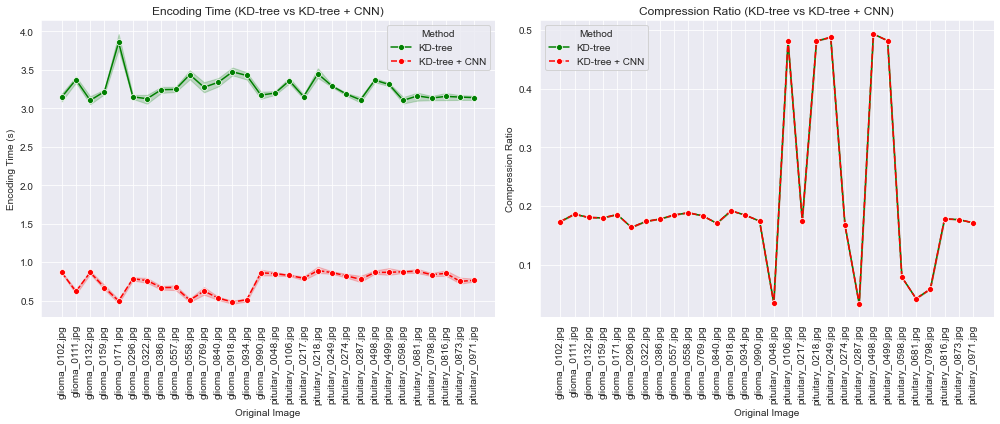

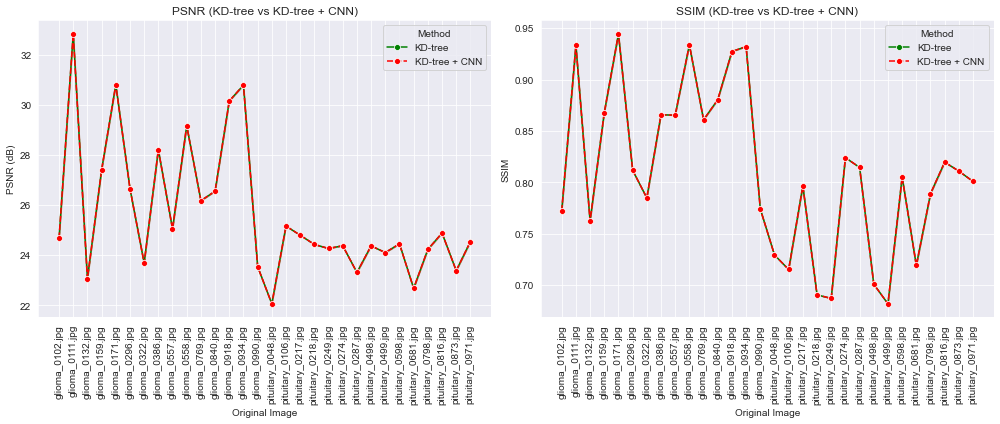

Average Data for Glioma Largest (KD-tree) method:


C:\Users\Tristan\AppData\Local\Temp\ipykernel_16672\567960013.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["Original Image"] = pd.Categorical(df_filtered["Original Image"], categories=image_list, ordered=True)


,Original Image,Original Image Size (KB),Compressed Image Size (KB),Compression Ratio,Build Tree Time (ms),Nearest Search Time (ms),CNN Inference Time (ms),Encoding Time (s),Decoding Time (s),PSNR (dB),SSIM,Blocks (blocks/s)
0,glioma_0132.jpg,53.32,9.64,0.1808,3.3454,3.0004,0.0,3.1028,0.0438,23.0564,0.7623,0.0
1,glioma_0990.jpg,53.23,9.30,0.1747,3.3126,3.0631,0.0,3.1708,0.0389,23.5434,0.7740,0.0
2,glioma_0322.jpg,52.54,9.14,0.1740,3.3157,3.0138,0.0,3.1240,0.0358,23.6845,0.7848,0.0
3,glioma_0296.jpg,52.20,8.55,0.1638,3.1989,3.0441,0.0,3.1484,0.0408,26.6525,0.8117,0.0
4,glioma_0102.jpg,50.99,8.86,0.1738,3.3425,3.0360,0.0,3.1442,0.0322,24.6696,0.7722,0.0




Average Data for Glioma Mid (KD-tree) method:


C:\Users\Tristan\AppData\Local\Temp\ipykernel_16672\567960013.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["Original Image"] = pd.Categorical(df_filtered["Original Image"], categories=image_list, ordered=True)


,Original Image,Original Image Size (KB),Compressed Image Size (KB),Compression Ratio,Build Tree Time (ms),Nearest Search Time (ms),CNN Inference Time (ms),Encoding Time (s),Decoding Time (s),PSNR (dB),SSIM,Blocks (blocks/s)
0,glioma_0840.jpg,34.00,5.81,0.1709,3.0210,3.2250,0.0,3.3369,0.0365,26.5523,0.8803,0.0
1,glioma_0557.jpg,34.01,6.29,0.1849,3.3353,3.1319,0.0,3.2446,0.0374,25.0440,0.8653,0.0
2,glioma_0386.jpg,34.02,6.06,0.1781,3.2737,3.1319,0.0,3.2412,0.0398,28.2083,0.8658,0.0
3,glioma_0769.jpg,34.04,6.25,0.1836,3.4201,3.1637,0.0,3.2726,0.0422,26.1737,0.8608,0.0
4,glioma_0159.jpg,34.04,6.13,0.1801,3.3993,3.1103,0.0,3.2157,0.0390,27.4012,0.8677,0.0




Average Data for Glioma Smallest (KD-tree) method:


C:\Users\Tristan\AppData\Local\Temp\ipykernel_16672\567960013.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["Original Image"] = pd.Categorical(df_filtered["Original Image"], categories=image_list, ordered=True)


,Original Image,Original Image Size (KB),Compressed Image Size (KB),Compression Ratio,Build Tree Time (ms),Nearest Search Time (ms),CNN Inference Time (ms),Encoding Time (s),Decoding Time (s),PSNR (dB),SSIM,Blocks (blocks/s)
0,glioma_0934.jpg,19.43,3.59,0.1848,3.1239,3.3160,0.0,3.4260,0.0462,30.7906,0.9321,0.0
1,glioma_0171.jpg,19.81,3.68,0.1858,4.6713,3.7196,0.0,3.8548,0.0420,30.8056,0.9444,0.0
2,glioma_0111.jpg,19.91,3.71,0.1863,3.3339,3.2558,0.0,3.3714,0.0342,32.8328,0.9333,0.0
3,glioma_0918.jpg,19.93,3.83,0.1922,3.1805,3.3583,0.0,3.4733,0.0381,30.1536,0.9273,0.0
4,glioma_0558.jpg,20.02,3.78,0.1888,3.1224,3.3233,0.0,3.4373,0.0350,29.1673,0.9338,0.0




Average Data for Pituitary Largest (KD-tree) method:


C:\Users\Tristan\AppData\Local\Temp\ipykernel_16672\567960013.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["Original Image"] = pd.Categorical(df_filtered["Original Image"], categories=image_list, ordered=True)


,Original Image,Original Image Size (KB),Compressed Image Size (KB),Compression Ratio,Build Tree Time (ms),Nearest Search Time (ms),CNN Inference Time (ms),Encoding Time (s),Decoding Time (s),PSNR (dB),SSIM,Blocks (blocks/s)
0,pituitary_0048.jpg,328.59,11.33,0.0345,3.3233,3.0876,0.0,3.1976,0.0377,22.0562,0.7293,0.0
1,pituitary_0681.jpg,266.28,11.32,0.0425,3.3035,3.0517,0.0,3.1601,0.0332,22.6735,0.7190,0.0
2,pituitary_0287.jpg,236.31,7.96,0.0337,3.6539,3.0071,0.0,3.1087,0.0387,23.3067,0.8145,0.0
3,pituitary_0798.jpg,147.91,8.68,0.0587,3.5728,3.0255,0.0,3.1331,0.0319,24.2288,0.7889,0.0
4,pituitary_0598.jpg,124.30,9.85,0.0792,3.4872,3.0023,0.0,3.1028,0.0382,24.4496,0.8051,0.0




Average Data for Pituitary Mid (KD-tree) method:


C:\Users\Tristan\AppData\Local\Temp\ipykernel_16672\567960013.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["Original Image"] = pd.Categorical(df_filtered["Original Image"], categories=image_list, ordered=True)


,Original Image,Original Image Size (KB),Compressed Image Size (KB),Compression Ratio,Build Tree Time (ms),Nearest Search Time (ms),CNN Inference Time (ms),Encoding Time (s),Decoding Time (s),PSNR (dB),SSIM,Blocks (blocks/s)
0,pituitary_0274.jpg,48.93,8.22,0.1680,3.1299,3.0707,0.0,3.1848,0.0316,24.3755,0.8240,0.0
1,pituitary_0873.jpg,48.93,8.67,0.1772,3.3675,3.0382,0.0,3.1451,0.0368,23.3793,0.8109,0.0
2,pituitary_0971.jpg,48.95,8.41,0.1718,3.3661,3.0294,0.0,3.1385,0.0310,24.5391,0.8008,0.0
3,pituitary_0816.jpg,48.95,8.73,0.1783,3.3416,3.0480,0.0,3.1539,0.0397,24.8807,0.8196,0.0
4,pituitary_0217.jpg,48.97,8.58,0.1752,4.2642,3.0453,0.0,3.1512,0.0353,24.7970,0.7965,0.0




Average Data for Pituitary Smallest (KD-tree) method:


C:\Users\Tristan\AppData\Local\Temp\ipykernel_16672\567960013.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["Original Image"] = pd.Categorical(df_filtered["Original Image"], categories=image_list, ordered=True)


,Original Image,Original Image Size (KB),Compressed Image Size (KB),Compression Ratio,Build Tree Time (ms),Nearest Search Time (ms),CNN Inference Time (ms),Encoding Time (s),Decoding Time (s),PSNR (dB),SSIM,Blocks (blocks/s)
0,pituitary_0106.jpg,20.61,9.92,0.4813,3.1620,3.2433,0.0,3.3575,0.0371,25.1625,0.7151,0.0
1,pituitary_0249.jpg,20.92,10.20,0.4876,3.3431,3.1782,0.0,3.2882,0.0374,24.2659,0.6870,0.0
2,pituitary_0498.jpg,20.98,10.35,0.4933,3.1414,3.2471,0.0,3.3649,0.0458,24.3704,0.7008,0.0
3,pituitary_0218.jpg,21.46,10.33,0.4814,26.5336,3.3057,0.0,3.4479,0.0358,24.4273,0.6904,0.0
4,pituitary_0499.jpg,21.79,10.50,0.4819,3.2797,3.1931,0.0,3.3091,0.0380,24.1036,0.6817,0.0


In [11]:
# AVERAGE OF VALUES FOR KD-TREE ONLY
df = pd.read_csv(multiTest_csvFile)

# Apply the conversion function to the "Compression Ratio" column
df["Compression Ratio"] = df["Compressed Image Size (KB)"] / df["Original Image Size (KB)"]

# Rename method labels
df["Method"] = df["Method"].replace({
    "kd-tree-only": "KD-tree",
    "proposed": "KD-tree + CNN"
})

# Filter only kd-tree-only and proposed methods
df_filtered = df[df["Method"].isin(["KD-tree", "KD-tree + CNN"])]
df_filtered = df_filtered.sort_values(by="Original Image")


# First plot: Encoding Time and Compression Ratio comparison for kd-tree-only vs proposed
# Set figure size
plt.figure(figsize=(14, 6))

# Plot 1: Encoding Time
plt.subplot(1, 2, 1)
sns.lineplot(
    data=df_filtered,
    x="Original Image",
    y="Encoding Time (s)",
    hue="Method",
    style="Method",
    marker="o",
    palette=palette
)
plt.xticks(rotation=90)
plt.title("Encoding Time (KD-tree vs KD-tree + CNN)")
plt.ylabel("Encoding Time (s)")
plt.xlabel("Original Image")
plt.grid(True)

# Plot 2: Compression Ratio
plt.subplot(1, 2, 2)
sns.lineplot(
    data=df_filtered,
    x="Original Image",
    y="Compression Ratio",
    hue="Method",
    style="Method",
    marker="o",
    palette=palette
)
plt.xticks(rotation=90)
plt.title("Compression Ratio (KD-tree vs KD-tree + CNN)")
plt.ylabel("Compression Ratio")
plt.xlabel("Original Image")
plt.grid(True)

plt.tight_layout()
plt.show()


# Second plot: PSNR and SSIM comparison for kd-tree-only vs proposed
# Set figure size
plt.figure(figsize=(14, 6))

# Plot 1: PSNR
plt.subplot(1, 2, 1)
sns.lineplot(
    data=df_filtered,
    x="Original Image",
    y="PSNR (dB)",
    hue="Method",
    style="Method",
    marker="o",
    palette=palette
)
plt.xticks(rotation=90)
plt.title("PSNR (KD-tree vs KD-tree + CNN)")
plt.ylabel("PSNR (dB)")
plt.xlabel("Original Image")
plt.grid(True)

# Plot 2: SSIM
plt.subplot(1, 2, 2)
sns.lineplot(
    data=df_filtered,
    x="Original Image",
    y="SSIM",
    hue="Method",
    style="Method",
    marker="o",
    palette=palette
)
plt.xticks(rotation=90)
plt.title("SSIM (KD-tree vs KD-tree + CNN)")
plt.ylabel("SSIM")
plt.xlabel("Original Image")
plt.grid(True)

plt.tight_layout()
plt.show()


# Group by "Original Image" and calculate the mean for each column for the kd-tree-only method
df_kd_tree = df[df["Method"] == "KD-tree"].groupby("Original Image").agg({
    "Original Image Size (KB)": "mean",
    "Compressed Image Size (KB)": "mean",
    "Compression Ratio": "mean",
    "Build Tree Time (ms)": "mean",
    "Nearest Search Time (ms)": "mean",
    "CNN Inference Time (ms)": "mean",
    "Encoding Time (s)": "mean",
    "Decoding Time (s)": "mean",
    "PSNR (dB)": "mean",
    "SSIM": "mean",
    "Blocks (blocks/s)": "mean"
}).reset_index()

# Function to display the averaged data while maintaining order
def display_avg_data(image_list, method_df, method_name):
    # Filter the DataFrame for the given "Original Image" values
    df_filtered = method_df[method_df["Original Image"].isin(image_list)]
    
    # Reorder the rows based on the image_list order
    df_filtered["Original Image"] = pd.Categorical(df_filtered["Original Image"], categories=image_list, ordered=True)
    df_filtered = df_filtered.sort_values("Original Image").reset_index(drop=True)

    # Round numeric columns to 4 decimal places
    df_filtered = df_filtered.round({
        "Original Image Size (KB)": 4,
        "Compressed Image Size (KB)": 4,
        "Compression Ratio": 4,
        "Build Tree Time (ms)": 4,
        "Nearest Search Time (ms)": 4,
        "CNN Inference Time (ms)": 4,
        "Encoding Time (s)": 4,
        "Decoding Time (s)": 4,
        "PSNR (dB)": 4,
        "SSIM": 4,
        "Blocks (blocks/s)": 4
    })
    
    # Display the filtered and ordered data
    print(f"Average Data for {method_name} method:")
    display(df_filtered[[ 
        "Original Image", "Original Image Size (KB)", "Compressed Image Size (KB)", 
        "Compression Ratio", "Build Tree Time (ms)", "Nearest Search Time (ms)", 
        "CNN Inference Time (ms)", "Encoding Time (s)", "Decoding Time (s)", 
        "PSNR (dB)", "SSIM", "Blocks (blocks/s)"
    ]])
    print("\n")

# Now, let's display the averaged data for each category using the kd-tree-only method
for category, image_list in zip(
    ["Glioma Largest", "Glioma Mid", "Glioma Smallest", 
     "Pituitary Largest", "Pituitary Mid", "Pituitary Smallest"],
    [glioma_Largest, glioma_Mid, glioma_Smallest, 
     pituitary_Largest, pituitary_Mid, pituitary_Smallest]):

    # Display averaged data for the kd-tree-only method
    display_avg_data(image_list, df_kd_tree, f"{category} (KD-tree)")

In [12]:
# AVERAGE OF VALUES FOR proposed (KD-TREE + CNN)
df = pd.read_csv(multiTest_csvFile)

# Apply the conversion function to the "Compression Ratio" column
df["Compression Ratio"] = df["Compressed Image Size (KB)"] / df["Original Image Size (KB)"]

# Group by "Original Image" and calculate the mean for each column for the proposed method
df_proposed = df[df["Method"] == "proposed"].groupby("Original Image").agg({
    "Original Image Size (KB)": "mean",
    "Compressed Image Size (KB)": "mean",
    "Compression Ratio": "mean",
    "Build Tree Time (ms)": "mean",
    "Nearest Search Time (ms)": "mean",
    "CNN Inference Time (ms)": "mean",
    "Encoding Time (s)": "mean",
    "Decoding Time (s)": "mean",
    "PSNR (dB)": "mean",
    "SSIM": "mean",
    "Blocks (blocks/s)": "mean"
}).reset_index()

# Function to display the averaged data while maintaining order
def display_avg_data(image_list, method_df, method_name):
    # Filter the DataFrame for the given "Original Image" values
    df_filtered = method_df[method_df["Original Image"].isin(image_list)]
    
    # Reorder the rows based on the image_list order
    df_filtered["Original Image"] = pd.Categorical(df_filtered["Original Image"], categories=image_list, ordered=True)
    df_filtered = df_filtered.sort_values("Original Image").reset_index(drop=True)

    # Round numeric columns to 4 decimal places
    df_filtered = df_filtered.round({
        "Original Image Size (KB)": 4,
        "Compressed Image Size (KB)": 4,
        "Compression Ratio": 4,
        "Build Tree Time (ms)": 4,
        "Nearest Search Time (ms)": 4,
        "CNN Inference Time (ms)": 4,
        "Encoding Time (s)": 4,
        "Decoding Time (s)": 4,
        "PSNR (dB)": 4,
        "SSIM": 4,
        "Blocks (blocks/s)": 4
    })
    
    # Display the filtered and ordered data
    print(f"Average Data for {method_name} method:")
    display(df_filtered[[ 
        "Original Image", "Original Image Size (KB)", "Compressed Image Size (KB)", 
        "Compression Ratio", "Build Tree Time (ms)", "Nearest Search Time (ms)", 
        "CNN Inference Time (ms)", "Encoding Time (s)", "Decoding Time (s)", 
        "PSNR (dB)", "SSIM", "Blocks (blocks/s)"
    ]])
    print("\n")

# Now, let's display the averaged data for each category using the proposed method
for category, image_list in zip(
    ["Glioma Largest", "Glioma Mid", "Glioma Smallest", 
     "Pituitary Largest", "Pituitary Mid", "Pituitary Smallest"],
    [glioma_Largest, glioma_Mid, glioma_Smallest, 
     pituitary_Largest, pituitary_Mid, pituitary_Smallest]):

    # Display averaged data for the proposed method
    display_avg_data(image_list, df_proposed, f"{category} (proposed)")

C:\Users\Tristan\AppData\Local\Temp\ipykernel_16672\615353774.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["Original Image"] = pd.Categorical(df_filtered["Original Image"], categories=image_list, ordered=True)


Average Data for Glioma Largest (proposed) method:


,Original Image,Original Image Size (KB),Compressed Image Size (KB),Compression Ratio,Build Tree Time (ms),Nearest Search Time (ms),CNN Inference Time (ms),Encoding Time (s),Decoding Time (s),PSNR (dB),SSIM,Blocks (blocks/s)
0,glioma_0132.jpg,53.32,9.64,0.1808,6.6578,0.7527,80.7028,0.8676,0.0413,23.0564,0.7623,1311.5195
1,glioma_0990.jpg,53.23,9.30,0.1747,6.2957,0.7654,58.9405,0.8616,0.0375,23.5434,0.7740,1291.3074
2,glioma_0322.jpg,52.54,9.14,0.1740,6.2151,0.6771,54.3107,0.7610,0.0416,23.6845,0.7848,1458.0117
3,glioma_0296.jpg,52.20,8.55,0.1638,6.4943,0.6977,54.0103,0.7851,0.0417,26.6525,0.8117,1413.9512
4,glioma_0102.jpg,50.99,8.86,0.1738,6.6838,0.7771,54.9253,0.8670,0.0390,24.6696,0.7722,1267.7057




Average Data for Glioma Mid (proposed) method:


C:\Users\Tristan\AppData\Local\Temp\ipykernel_16672\615353774.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["Original Image"] = pd.Categorical(df_filtered["Original Image"], categories=image_list, ordered=True)


,Original Image,Original Image Size (KB),Compressed Image Size (KB),Compression Ratio,Build Tree Time (ms),Nearest Search Time (ms),CNN Inference Time (ms),Encoding Time (s),Decoding Time (s),PSNR (dB),SSIM,Blocks (blocks/s)
0,glioma_0840.jpg,34.00,5.81,0.1709,5.8982,0.4511,53.1622,0.5339,0.0381,26.5523,0.8803,2183.2020
1,glioma_0557.jpg,34.01,6.29,0.1849,6.2365,0.5859,54.1892,0.6718,0.0449,25.0440,0.8653,1685.7117
2,glioma_0386.jpg,34.02,6.06,0.1781,6.3568,0.5846,58.8100,0.6695,0.0369,28.2083,0.8658,1689.9526
3,glioma_0769.jpg,34.04,6.25,0.1836,6.6286,0.5419,54.1485,0.6243,0.0423,26.1737,0.8608,1827.2344
4,glioma_0159.jpg,34.04,6.13,0.1801,7.4667,0.5833,55.7683,0.6706,0.0432,27.4012,0.8677,1691.7942




Average Data for Glioma Smallest (proposed) method:


C:\Users\Tristan\AppData\Local\Temp\ipykernel_16672\615353774.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["Original Image"] = pd.Categorical(df_filtered["Original Image"], categories=image_list, ordered=True)


,Original Image,Original Image Size (KB),Compressed Image Size (KB),Compression Ratio,Build Tree Time (ms),Nearest Search Time (ms),CNN Inference Time (ms),Encoding Time (s),Decoding Time (s),PSNR (dB),SSIM,Blocks (blocks/s)
0,glioma_0934.jpg,19.43,3.59,0.1848,6.1756,0.4331,56.1933,0.5116,0.0378,30.7906,0.9321,2271.9627
1,glioma_0171.jpg,19.81,3.68,0.1858,6.8416,0.4209,53.8577,0.4969,0.0381,30.8056,0.9444,2341.6878
2,glioma_0111.jpg,19.91,3.71,0.1863,6.8546,0.5392,52.2267,0.6190,0.0437,32.8328,0.9333,1833.0658
3,glioma_0918.jpg,19.93,3.83,0.1922,6.2472,0.4104,53.8729,0.4817,0.0423,30.1536,0.9273,2404.4530
4,glioma_0558.jpg,20.02,3.78,0.1888,6.3433,0.4300,53.1278,0.5065,0.0337,29.1673,0.9338,2292.1217




Average Data for Pituitary Largest (proposed) method:


C:\Users\Tristan\AppData\Local\Temp\ipykernel_16672\615353774.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["Original Image"] = pd.Categorical(df_filtered["Original Image"], categories=image_list, ordered=True)


,Original Image,Original Image Size (KB),Compressed Image Size (KB),Compression Ratio,Build Tree Time (ms),Nearest Search Time (ms),CNN Inference Time (ms),Encoding Time (s),Decoding Time (s),PSNR (dB),SSIM,Blocks (blocks/s)
0,pituitary_0048.jpg,328.59,11.33,0.0345,5.4549,0.7638,52.8323,0.8513,0.0446,22.0562,0.7293,1291.3221
1,pituitary_0681.jpg,266.28,11.32,0.0425,5.8981,0.7822,61.5476,0.8826,0.0359,22.6735,0.7190,1262.9396
2,pituitary_0287.jpg,236.31,7.96,0.0337,11.9027,0.6737,62.6944,0.7778,0.0352,23.3067,0.8145,1465.2126
3,pituitary_0798.jpg,147.91,8.68,0.0587,6.2823,0.7402,61.8256,0.8376,0.0394,24.2288,0.7889,1333.4976
4,pituitary_0598.jpg,124.30,9.85,0.0792,7.0723,0.7776,62.9959,0.8756,0.0362,24.4496,0.8051,1269.9880




Average Data for Pituitary Mid (proposed) method:


C:\Users\Tristan\AppData\Local\Temp\ipykernel_16672\615353774.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["Original Image"] = pd.Categorical(df_filtered["Original Image"], categories=image_list, ordered=True)


,Original Image,Original Image Size (KB),Compressed Image Size (KB),Compression Ratio,Build Tree Time (ms),Nearest Search Time (ms),CNN Inference Time (ms),Encoding Time (s),Decoding Time (s),PSNR (dB),SSIM,Blocks (blocks/s)
0,pituitary_0274.jpg,48.93,8.22,0.1680,5.9728,0.7256,62.4409,0.8224,0.0388,24.3755,0.8240,1362.2078
1,pituitary_0873.jpg,48.93,8.67,0.1772,6.9813,0.6537,64.0465,0.7504,0.0339,23.3793,0.8109,1515.2485
2,pituitary_0971.jpg,48.95,8.41,0.1718,6.3578,0.6749,63.3596,0.7648,0.0431,24.5391,0.8008,1463.2276
3,pituitary_0816.jpg,48.95,8.73,0.1783,6.1995,0.7594,62.9293,0.8545,0.0454,24.8807,0.8196,1300.4135
4,pituitary_0217.jpg,48.97,8.58,0.1752,6.6002,0.6943,63.6220,0.7914,0.0324,24.7970,0.7965,1422.4915




Average Data for Pituitary Smallest (proposed) method:


C:\Users\Tristan\AppData\Local\Temp\ipykernel_16672\615353774.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["Original Image"] = pd.Categorical(df_filtered["Original Image"], categories=image_list, ordered=True)


,Original Image,Original Image Size (KB),Compressed Image Size (KB),Compression Ratio,Build Tree Time (ms),Nearest Search Time (ms),CNN Inference Time (ms),Encoding Time (s),Decoding Time (s),PSNR (dB),SSIM,Blocks (blocks/s)
0,pituitary_0106.jpg,20.61,9.92,0.4813,6.4164,0.7332,62.0284,0.8273,0.0435,25.1625,0.7151,1345.4440
1,pituitary_0249.jpg,20.92,10.20,0.4876,6.0914,0.7637,61.6396,0.8649,0.0365,24.2659,0.6870,1293.4237
2,pituitary_0498.jpg,20.98,10.35,0.4933,6.0690,0.7654,63.4991,0.8662,0.0413,24.3704,0.7008,1290.3256
3,pituitary_0218.jpg,21.46,10.33,0.4814,6.2820,0.7893,62.2281,0.8907,0.0419,24.4273,0.6904,1255.7941
4,pituitary_0499.jpg,21.79,10.50,0.4819,6.5129,0.7471,87.3947,0.8682,0.0374,24.1036,0.6817,1321.0783


In [13]:
# looking for data to be used in the paper based on [largest, mid, smallest] image size
df = pd.read_csv(enhanced_csvFile)

# Add a 'Category' column based on filename prefix
df['Category'] = df['Original Image'].apply(lambda x: 'Glioma' if 'glioma' in x.lower() else 'Pituitary' if 'pituitary' in x.lower() else 'Unknown')

# Process each category
for category in ['Glioma', 'Pituitary']:
    print(f"\n===== Category: {category} =====")
    
    df_cat = df[df['Category'] == category].copy()
    df_sorted = df_cat.sort_values(by="Original Image Size (KB)", ascending=True).reset_index(drop=True)

    # Get 5 smallest
    smallest = df_sorted.head(5).reset_index(drop=True)

    # Get 5 largest
    largest = df_sorted.tail(5).reset_index(drop=True)

    # Get 5 mid (2 before, exact middle, 2 after)
    total = len(df_sorted)
    if total >= 5:
        mid_index = total // 2
        start = max(0, mid_index - 2)
        end = min(total, mid_index + 3)
        mid = df_sorted.iloc[start:end].reset_index(drop=True)
    else:
        mid = df_sorted.iloc[[total // 2]].reset_index(drop=True)

    # Display results
    print("\nLargest:")
    for i, row in largest.iloc[::-1].reset_index(drop=True).iterrows():
        print(f"{i+1}. {row['Original Image']} - {row['Original Image Size (KB)']} KB")

    print("\nMid:")
    for i, row in mid.iterrows():
        print(f"{i+1}. {row['Original Image']} - {row['Original Image Size (KB)']} KB")

    print("\nSmallest:")
    for i, row in smallest.iterrows():
        print(f"{i+1}. {row['Original Image']} - {row['Original Image Size (KB)']} KB")

    print("\n\n")



===== Category: Glioma =====

Largest:
1. glioma_0132.jpg - 53.32 KB
2. glioma_0990.jpg - 53.23 KB
3. glioma_0322.jpg - 52.54 KB
4. glioma_0296.jpg - 52.2 KB
5. glioma_0102.jpg - 50.99 KB

Mid:
1. glioma_0840.jpg - 34.0 KB
2. glioma_0557.jpg - 34.01 KB
3. glioma_0386.jpg - 34.02 KB
4. glioma_0769.jpg - 34.04 KB
5. glioma_0159.jpg - 34.04 KB

Smallest:
1. glioma_0934.jpg - 19.43 KB
2. glioma_0171.jpg - 19.81 KB
3. glioma_0111.jpg - 19.91 KB
4. glioma_0918.jpg - 19.93 KB
5. glioma_0558.jpg - 20.02 KB




===== Category: Pituitary =====

Largest:
1. pituitary_0048.jpg - 328.59 KB
2. pituitary_0681.jpg - 266.28 KB
3. pituitary_0287.jpg - 236.31 KB
4. pituitary_0798.jpg - 147.91 KB
5. pituitary_0598.jpg - 124.3 KB

Mid:
1. pituitary_0274.jpg - 48.93 KB
2. pituitary_0873.jpg - 48.93 KB
3. pituitary_0971.jpg - 48.95 KB
4. pituitary_0816.jpg - 48.95 KB
5. pituitary_0217.jpg - 48.97 KB

Smallest:
1. pituitary_0106.jpg - 20.61 KB
2. pituitary_0249.jpg - 20.92 KB
3. pituitary_0498.jpg - 20.98 KB